In [8]:
import cv2
import matplotlib.pyplot as plt
import time
import numpy as np
import tensorflow as tf

In [9]:
# Load the model
model = tf.keras.models.load_model("cnn12-2.h5")

In [10]:
!pip install paho-mqtt

import paho.mqtt.client as mqtt

In [11]:
### TODO: Paste IoU function here
def IoU(box_predicted, box_true, verbose = True):
    (x1_pred, y1_pred, x2_pred, y2_pred) = box_predicted
    (x1_true, y1_true, x2_true, y2_true) = box_true

    # calculate intersection area
    xx1 = np.maximum(x1_pred, x1_true)
    yy1 = np.maximum(y1_pred, y1_true)
    xx2 = np.minimum(x2_pred, x2_true)
    yy2 = np.minimum(y2_pred, y2_true)

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
    intersectionArea = w * h

    if verbose:
        print("w:", w)
        print("h:", h)
        print("Intersection area:", intersectionArea)

    # calculate the areas for the prediction and ground-truth (true) boxes
    boxPredictedArea = (x2_pred - x1_pred + 1) * (y2_pred - y1_pred + 1)
    boxTrueArea = (x2_true - x1_true + 1) * (y2_true - y1_true + 1)

    # calculate the union area
    unionArea = boxPredictedArea + boxTrueArea - intersectionArea

    if verbose:
        print("Union area:", unionArea)

    # return IoU
    return intersectionArea / float(unionArea)

In [12]:
def NMS(boxes, probs, threshold=0.5, verbose=False):# to remove the rectangles
    D_index = []

    # sort indexes by probability
    B_index = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes list
    while len(B_index) > 0:
        # append the index of the rectangle with the highest probability to D
        last = len(B_index) - 1
        d_index = B_index[last]
        D_index.append(d_index)
        B_index = np.delete(B_index, [last]) # delete the index from index list B

        overlaps=[]
        for b_index in B_index[:last]: #
            b = boxes[b_index]
            d = boxes[d_index]
            ### TODO: Calculate the overlap between the two boxes
            overlap = IoU(b, d, verbose=verbose)
            ### TODO: Append overlap to list overlaps
            overlaps.append(overlap)

        overlaps = np.asarray(overlaps) # convert to array, necessary for comparison below (np.where(overlaps > threshold))

        # delete candidate rectangles (indexes) from B who overlap greather than the threshold hyper parameter
        indexes_to_delete = np.where(overlaps > threshold)
        ### TODO: Remove the indexes 'indexes_to_delete' from index list B
        B_index = np.delete(B_index, indexes_to_delete[0])

    return D_index

In [13]:
def read_img(path, ratio=.1):
  """
      Function to read an image from path (the image received from the App
      will be saved and then read again using this function)
  """
  img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
  if img.size > 1000000:
     img = cv2.resize(img, (0,0), fx=ratio, fy=ratio)

  return img

In [14]:
def create_selective_regions(img):
  """
      Create Regions from img: takes random regions "Boxes" from the image
  """
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # selective search
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()
  rects = ss.process()
  print("Number of found rectangles: " + str(len(rects)))
  return rects

In [15]:
def create_mini_images(img, rects):
  """
      Transform the rectangles (the coordinates x,y,w,h) into small images
  """
  imgs = []
  for (startX, startY, width, height) in rects: # iterate through all interesting regions
      imgs.append(img[startY:(startY + height), startX:(startX + width)]) # extract the interesting region from the image, add
  return imgs

In [16]:
def preprocess_imgs(imgs, inputsize):
    """
        Resize the images and normalize (transform the values to a range 0,1)
    """
    for i in range(len(imgs)):
        # resize it to the required input dimensions of our trained CNN
        imgs[i] = cv2.resize(imgs[i], inputsize, interpolation=cv2.INTER_CUBIC)
        # normalize the pixel values
        imgs[i] = imgs[i] * 1./255
    return imgs

def prob_and_label_multiple_imgs(imgs, inputsize = (56, 56)):
    """
        Feed the images to the model and get the classes and probabilities
    """
    print("\nDetecting the class of each region:")
    (H, W) = inputsize
    imgs = preprocess_imgs(imgs, inputsize)
    imgs = np.resize(imgs, (len(imgs), H, W, 3)) # array size: number of images(len(imgs))x56x56x3(RGB)
    preds = model.predict(imgs)
    print("Done!\n")
    probs = np.max(preds, axis=-1)
    labels = np.argmax(preds, axis=-1)
    return (probs, labels)


################################################################
##    The result here will be classes and its propabilities   ##
################################################################

In [17]:
def remove_background(probs, labels, rects):
    """
        Remove the background regions (boxes) and their probabilities to be able to feed them to the NMS algorithm
        NMS only needs candidate boxes/regions and no background boxes
    """
    new_labels = []
    new_rects = []
    new_probs = []
    for x in np.unique(labels):
          if x!= 43: # class 43 is the background
              indexes = np.where(labels == x)[0]
              for i in indexes:
                  new_probs.append(probs[i])
                  new_rects.append(rects[i].tolist())
                  new_labels.append(x)
    return new_probs, new_labels, new_rects


def fill_output_dict(boxes, labels):
    """
        Make the output as a dictionary so that each key is the class/label of the shild and the value is coordinates of the box(es)
        Value can be multiple boxes per class because an image can have 2 shilds of the same type.
    """
    output = {}
    for x in np.unique(labels):
        indexes = np.where(labels==x)[0]
        output[x] = [boxes[i] for i in indexes]
    return output

def perform_nms_on_candidate_rectangles(probs, labels, rects, threshold=.5):
    """
        Perform NMS on the boxes and get the ...
    """
    probs, labels, rects = remove_background(probs, labels, rects)
    rects = [convert_xywh_to_xxyy(x) for x in rects ]
    D_index = NMS(rects, probs, threshold=threshold)
    selected_boxes = [rects[i] for i in D_index]
    selected_labels = [labels[i] for i in D_index]
    output = fill_output_dict(selected_boxes, selected_labels)
    return output

In [18]:
def convert_xywh_to_xxyy(rect):
    startX, startY, width, height = rect
    return startX, startY, (startX + width), (startY + height)

In [19]:
def detect_shild(path, ratio=1., threshold=.5):
    """
        This is the main function.
        This performs:
          - Read image
          - Select regions
          - Get mini images
          - Feed mini images to model and get class-prob sets for each mini image
          - Perform NMS on the regions and get final result
    """
    img = read_img(path, ratio)
    rects = create_selective_regions(img)
    imgs = create_mini_images(img, rects)
    (probs, labels) = prob_and_label_multiple_imgs(imgs)
    output = perform_nms_on_candidate_rectangles(probs, labels, rects, threshold)
    return output

# Test

In [20]:
path="img17.jpeg"
RATIO = .1
THRESHOLD = .001

In [21]:
output_rects = detect_shild(path=path, ratio=RATIO, threshold=THRESHOLD)
output_rects

Number of found rectangles: 225

Detecting the class of each region:
8/8 [==============================] - 1s 74ms/step
Done!



{12: [(52, 47, 77, 78)], 28: [(15, 60, 32, 72)]}

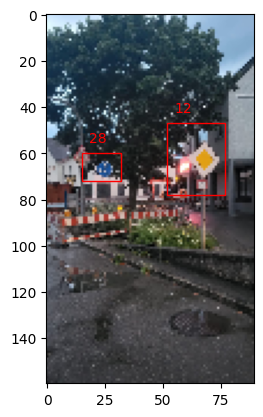

In [22]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
img = read_img(path, ratio=RATIO)
ax.imshow(img)

for key in output_rects.keys():
  c_rect = output_rects[key]
  for x in c_rect:
    rect = patches.Rectangle((x[0],x[1]), x[2]-x[0], x[3]-x[1], linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.text(x[0]+3,x[1]-5, key, color="r")

plt.show()
# plt.imshow(img)



# MQTT Loop: Run this

In [ ]:
import paho.mqtt.client as mqtt

# The callback for when the client receives a CONNACK response from the server.
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))

    # Subscribing in on_connect() means that if we lose the connection and
    # reconnect then subscriptions will be renewed.
    client.subscribe("adas/image") ########### Receive from app

# The callback for when a PUBLISH message is received from the server.
def on_message(client, userdata, msg):
    try:

      if msg.topic.startswith("adas/image"):
        with open("img.jpg", "wb") as f1:
          f1.write(msg.payload)

        # Process the Image
        result = detect_shild(path="img.jpg")
        client.publish("adas/", f"{result}") ############# Send to app

    except Exception as e:
      print("Error processing the messages::", repr(e))

client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message

client.connect("194.95.24.122", 1883, 60)

# Blocking call that processes network traffic, dispatches callbacks and
# handles reconnecting.
# Other loop*() functions are available that give a threaded interface and a
# manual interface.
client.loop_forever()

<ipython-input-23-54c2666f7dec>:26: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


Connected with result code 0
Error processing the messages:: error("OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'\n")
Error processing the messages:: error("OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'\n")
Error processing the messages:: error("OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'\n")
Error processing the messages:: error("OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'\n")
Error processing the messages:: error("OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'\n")
Error processing the messages:: error("OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Asse